# Exporatory Data Analysis

Exploratory data analysis of Non-HN dataset.

_NB.: using `maths` conda environment of `@paultsw`'s computer._

In [1]:
# import the usual suspects for EDA:
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# system utils:
import csv
import sys
import os
import pprint
from collections import Counter
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, trange

In [2]:
# sklearn tools:
#from sklearn import (...)

In [3]:
# gensim:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, FastText

- - - - -
## I. import dataset and do some basic checks.

In [4]:
data_df = pd.read_csv("../data/data.csv", index_col=False)
noneng_df = data_df[data_df['noneng'] == 1]
eng_df = data_df[data_df['noneng'] == 0]
data_df.head(10)

,title,url,noneng
0,git from the inside out,recurse,0
1,all back issues of omni magazine now available...,boingboing,1
2,cellphone spy tools have flooded local police ...,citylab,1
3,how to set up a super productive docker develo...,nrempel,0
4,the metrics vcs actually care about,heavybit,0
5,palantir sued over alleged hiring discrimination,wsj,0
6,graphicsmagick image processing system,graphicsmagick,0
7,video infrastructure as a service the bitmovi...,bitmovin,0
8,tech employees tell your ceo to boycott the tr...,techsolidarity,0
9,delta functions pdf,berkeley,0


In [5]:
noneng_df = data_df[data_df['noneng'] == 1]
eng_df = data_df[data_df['noneng'] == 0]

count_noneng = noneng_df.shape[0]
count_eng = eng_df.shape[0]
print("Num. non-eng: {}".format(count_noneng))
print("Num. eng: {}".format(count_eng))
print("Ratio (Non-Eng : Eng) = {}%".format(100. * count_noneng / float(count_eng)))

Num. non-eng: 1626
Num. eng: 8263
Ratio (Non-Eng : Eng) = 19.6780830207%


## II. examine some word statistics and generate a pool of unique words.

In [16]:
# stats we are interested in:
# 
# num. of samples: 9888
# num. of classes: 2
# num. of samples per class: 8263(0), 1625(1)
# num. of words per sample (median):
#     - Title: 9.0 (noneng), 8.0 (eng)
#     - URL: 1.0, 1.0
#


noneng_words_per_sample = []
noneng_words = []

eng_words_per_sample = []
eng_words = []

for sentence in list(data_df[data_df['noneng'] == 1]['title'].values):
    words = sentence.split(' ')
    noneng_words.extend(words)
    noneng_words_per_sample.append(len(words))

for sentence in list(data_df[data_df['noneng'] == 0]['title'].values):
    words = sentence.split(' ')
    eng_words.extend(words)
    eng_words_per_sample.append(len(words))

# all_words = noneng_words + eng_words
# temp = Counter([x for x in all_words if x not in ENGLISH_STOP_WORDS])
# pprint.pprint(temp.most_common(10000)[5500])



url_noneng_words = []
url_eng_words = []
for sentence in list(data_df[data_df['noneng'] == 1]['url'].values):
    words = sentence.split(' ')
    url_noneng_words.extend(words)
    url_noneng_words.append(len(words))

for sentence in list(data_df[data_df['noneng'] == 0]['url'].values):
    words = sentence.split(' ')
    url_eng_words.extend(words)
    url_eng_words.append(len(words))

url_all_words = url_noneng_words + url_eng_words
temp2 = Counter([x for x in url_all_words if x not in ENGLISH_STOP_WORDS])
pprint.pprint(temp2.most_common(10000)[100])

('technologyreview', 11)


# II. Plot frequency distributions

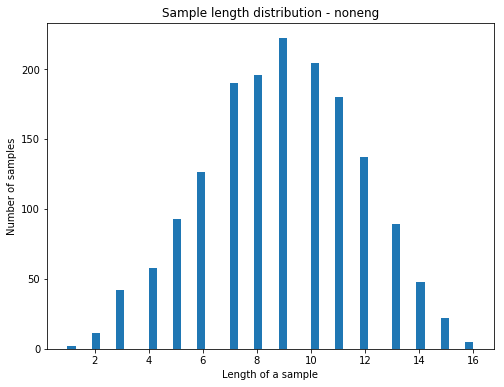

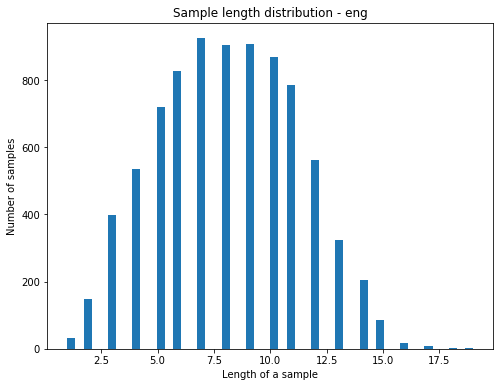

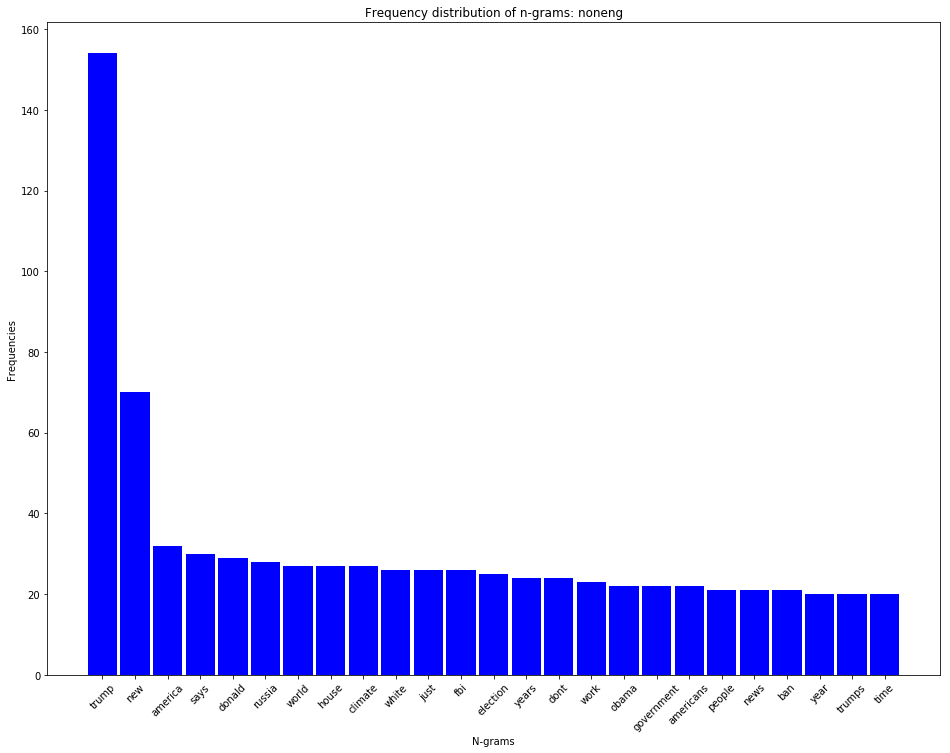

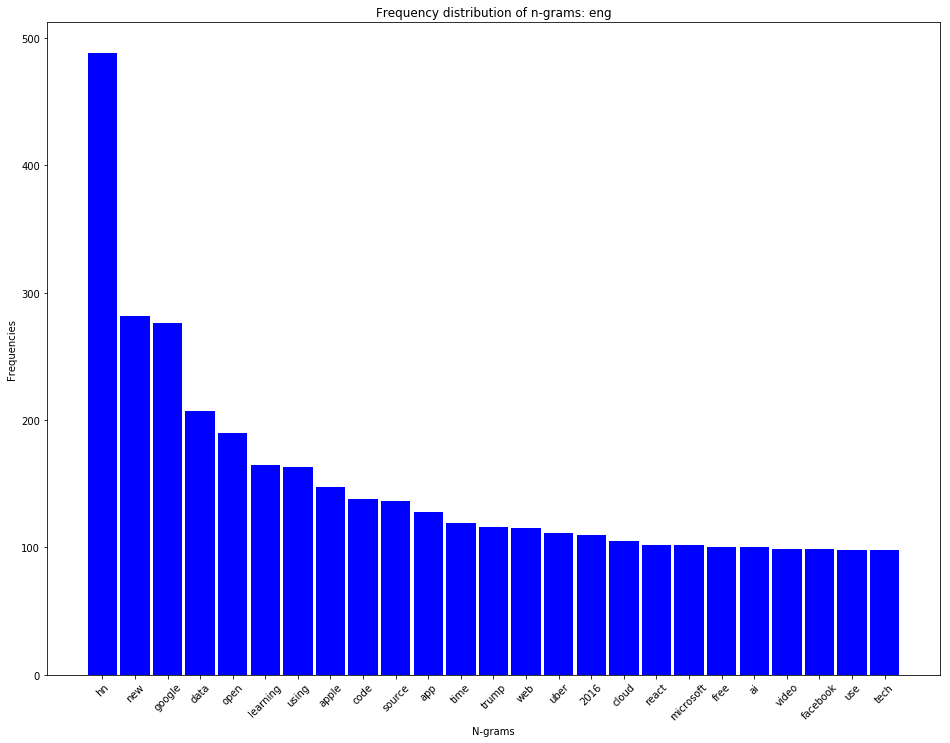

In [85]:
def plot_sample_length_distribution(sample_texts, title):
    plt.figure(figsize=(8,6))
    plt.hist([len(s.split(' ')) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.show()

plot_sample_length_distribution(noneng_df['title'], 'Sample length distribution - noneng')
plot_sample_length_distribution(eng_df['title'], 'Sample length distribution - eng')

# via https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/explore_data.py
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          class_,
                                          ngram_range=(1, 2),
                                          num_ngrams=25):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(16,12))
    plt.bar(idx, counts, width=0.9, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams: %s' % class_)
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

# print noneng_words
plot_frequency_distribution_of_ngrams([w for w in noneng_words if w not in ENGLISH_STOP_WORDS], 'noneng')
plot_frequency_distribution_of_ngrams([w for w in eng_words if w not in ENGLISH_STOP_WORDS], 'eng')


## III. exploration of word embedding models: Word2Vec, FastText

In [19]:
# get formatted list of lists of words from all titles:
all_sentences = [s.strip().split() for s in data_df['title'].values]
# ... from just the engineering titles:
eng_sentences = [s.strip().split() for s in data_df[data_df['noneng'] == 0]['title'].values]
# ... and from just the non-engineering titles:
noneng_sentences = [s.strip().split() for s in data_df[data_df['noneng'] == 1]['title'].values]

In [21]:
# train a word2vec model on all sentences:
# arguments:
# size ~ dimension of embedding vector space
# window ~ window size of each word
# min_count ~ ignore words that appear fewer than min_count times in the entire corpus of data
# workers ~ threads to use
# sg ~ if 1, use skip-gram training (0 -> continuous bag-of-words model; we're using skip-gram for rare words)
model_w2v = Word2Vec(sentences=all_sentences, size=100, window=5, min_count=5, workers=3, sg=1)

In [25]:
# check out a few most-similar-words evaluations on some random words and compute distances:
model_w2v.wv.most_similar("campaign")

[('safety', 0.9989723563194275),
 ('releasing', 0.9985957145690918),
 ('contains', 0.9985491037368774),
 ('readers', 0.9985160827636719),
 ('next-gen', 0.9984472990036011),
 ('eu', 0.9984416365623474),
 ('girl', 0.9984038472175598),
 ('xss', 0.9983392953872681),
 ('collects', 0.9983255863189697),
 ('picks', 0.9982678890228271)]

In [33]:
[np.sum(np.power(model_w2v.wv['campaign'] - model_w2v.wv[_word], 2.)) for _word in ['safety', 'contains', 'next-gen']]

[0.024290895, 0.06838648, 0.04055692]

In [26]:
model_w2v.wv.most_similar("internet")

[('happened', 0.9939441084861755),
 ('almost', 0.9933430552482605),
 ('cost', 0.9920545816421509),
 ('replace', 0.9913919568061829),
 ('broken', 0.9913278818130493),
 ('startups', 0.9911482334136963),
 ('employees', 0.9910067915916443),
 ('america', 0.99090576171875),
 ('his', 0.9904655814170837),
 ('genius', 0.9904117584228516)]

In [34]:
[np.sum(np.power(model_w2v.wv['internet'] - model_w2v.wv[_word], 2.)) for _word in ['happened', 'broken', 'genius']]

[0.028187377, 0.04174581, 0.040919397]

In [27]:
model_w2v.wv.most_similar("right")

[('slower', 0.9909306764602661),
 ('long', 0.9904853105545044),
 ('fall', 0.9897018074989319),
 ('safer', 0.9895232915878296),
 ('2007', 0.989295482635498),
 ('worth', 0.9891735315322876),
 ('cobol', 0.988878607749939),
 ('cpython', 0.9883400797843933),
 ('solve', 0.9883016347885132),
 ('easiest', 0.9879031777381897)]

In [35]:
[np.sum(np.power(model_w2v.wv['right'] - model_w2v.wv[_word], 2.)) for _word in ['slower', 'worth', 'cobol']]

[0.0458754, 0.047672693, 0.19075617]

In [28]:
model_w2v.wv.most_similar("costs")

[('lawsuit', 0.9985125064849854),
 ('sun', 0.9983959197998047),
 ('december', 0.998370349407196),
 ('patches', 0.9980621337890625),
 ('drupal', 0.9978747367858887),
 ('paris', 0.9977258443832397),
 ('sequel', 0.9976789355278015),
 ('rights', 0.9974321126937866),
 ('shares', 0.9973852634429932),
 ('follow', 0.9973822832107544)]

In [36]:
[np.sum(np.power(model_w2v.wv['costs'] - model_w2v.wv[_word], 2.)) for _word in ['lawsuit', 'paris', 'shares']]

[0.0120189395, 0.06709887, 0.064355806]

In [29]:
model_w2v.wv.most_similar("electric")

[('illegal', 0.9990853071212769),
 ('radios', 0.9990560412406921),
 ('bubble', 0.9990074634552002),
 ('acquisition', 0.9990014433860779),
 ('japan', 0.9989989995956421),
 ('strange', 0.9989743828773499),
 ('39', 0.9989455342292786),
 ('accused', 0.9989310503005981),
 ('500m', 0.9989277124404907),
 ('spacex', 0.9989216923713684)]

In [37]:
[np.sum(np.power(model_w2v.wv['electric'] - model_w2v.wv[_word], 2.)) for _word in ['illegal', 'strange', 'spacex']]

[0.0027745592, 0.004293309, 0.011509068]